<a href="https://colab.research.google.com/github/vinitphulwani/File-O-QR/blob/main/studentDropoutprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Install lib
!pip install pandas scikit-learn xgboost shap


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb
import shap

# Set a random seed for reproducibility
RSEED = 42

In [36]:

file_name = 'student_dropout_prediction.csv'

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name)

# Display the first few rows and information to verify load and inspect data
print(f"Data successfully loaded. Shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
display(df.head())
print("\nData Information:")
df.info()

Data successfully loaded. Shape: (1000, 5)

First 5 rows of the dataset:


,student_id,attendance,grades,support,dropout
0,S0001,50,69,2,1
1,S0002,49,83,10,0
2,S0003,91,90,3,0
3,S0004,79,93,10,0
4,S0005,90,79,5,0



Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  1000 non-null   object
 1   attendance  1000 non-null   int64 
 2   grades      1000 non-null   int64 
 3   support     1000 non-null   int64 
 4   dropout     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


In [37]:
# 1. Define the Target Column and Features
TARGET_COL = 'dropout'
X = df.drop(columns=['student_id', TARGET_COL], axis=1)
y = df[TARGET_COL]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFirst 5 rows of Features (X):")
display(X.head())

Features (X) shape: (1000, 3)
Target (y) shape: (1000,)

First 5 rows of Features (X):


,attendance,grades,support
0,50,69,2
1,49,83,10
2,91,90,3
3,79,93,10
4,90,79,5


In [38]:
# Check the class balance (Assuming '1' is 'Dropout' and '0' is 'No Dropout')
print("\nTarget Class Distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True) * 100)



Target Class Distribution:
dropout
0    661
1    339
Name: count, dtype: int64
dropout
0    66.1
1    33.9
Name: proportion, dtype: float64


In [39]:
from sklearn.preprocessing import StandardScaler

# Initialize the Scaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeatures after Standardization:")
display(X_scaled_df.head())


Features after Standardization:


,attendance,grades,support
0,-1.089016,-0.019863,-0.904524
1,-1.145208,0.765672,1.622079
2,1.214887,1.158439,-0.588698
3,0.540574,1.326768,1.622079
4,1.158695,0.541233,0.042952


In [40]:
from sklearn.model_selection import train_test_split


RSEED = 42 # Random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=RSEED, stratify=y
)

print(f"\n--- Data Split Summary ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Dropout % in Training Set: {y_train.mean() * 100:.2f}%")
print(f"Dropout % in Testing Set: {y_test.mean() * 100:.2f}%")


--- Data Split Summary ---
X_train shape: (800, 3), y_train shape: (800,)
X_test shape: (200, 3), y_test shape: (200,)
Dropout % in Training Set: 33.88%
Dropout % in Testing Set: 34.00%


In [41]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


RSEED = 42

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=RSEED,

    n_estimators=100,
    learning_rate=0.1
)

# Train the model
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("Training complete.")

Training XGBoost model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:15:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.



--- Model Evaluation ---
Accuracy: 0.6600

Classification Report (Key Metrics):
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       132
           1       0.50      0.37      0.42        68

    accuracy                           0.66       200
   macro avg       0.61      0.59      0.59       200
weighted avg       0.64      0.66      0.64       200



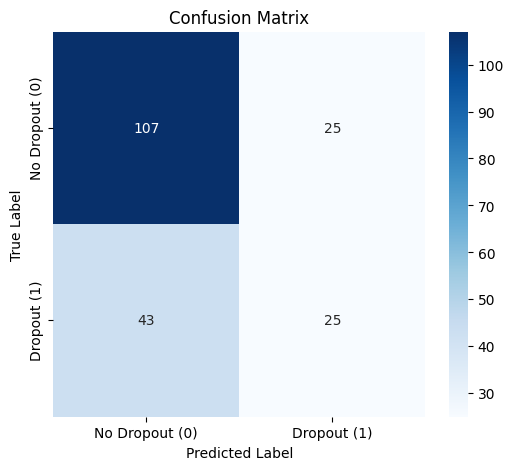

In [42]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

#  Model Evaluation Metrics
print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report (Key Metrics):")

print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Dropout (0)', 'Dropout (1)'],
            yticklabels=['No Dropout (0)', 'Dropout (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- SHAP Summary Plot (Global Feature Importance) ---


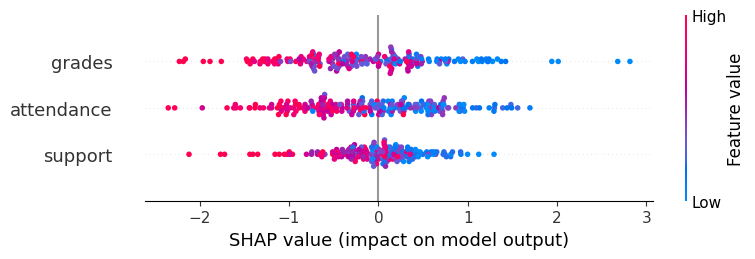


--- SHAP Bar Plot (Ranking by Average Impact) ---


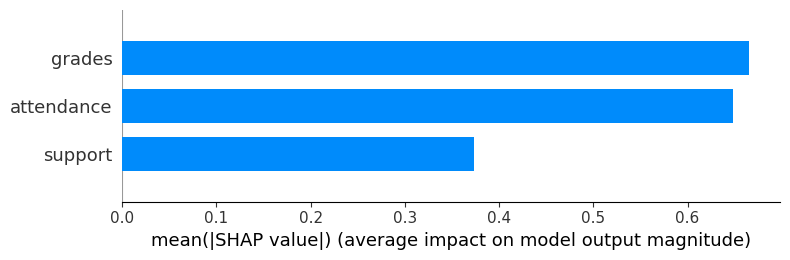

In [43]:
import shap

explainer = shap.TreeExplainer(xgb_model)


shap_values = explainer.shap_values(X_test)

print("\n--- SHAP Summary Plot (Global Feature Importance) ---")

shap.summary_plot(shap_values, X_test)



print("\n--- SHAP Bar Plot (Ranking by Average Impact) ---")

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [44]:
# Select a student from the test set for a deep dive (e.g., student at index 10)

student_index = 10
student_data = X_test.iloc[[student_index]]

actual_value = y_test.iloc[student_index]

print(f"\n--- Local Explanation for Student Index {student_index} ---")
print(f"Model Prediction: {'Dropout (1)' if prediction == 1 else 'No Dropout (0)'}")
print(f"Actual Outcome:   {'Dropout (1)' if actual_value == 1 else 'No Dropout (0)'}")


shap.initjs()


shap.force_plot(
    explainer.expected_value,
    shap_values[student_index, :],
    student_data.iloc[0]
)


--- Local Explanation for Student Index 10 ---
Model Prediction: No Dropout (0)
Actual Outcome:   No Dropout (0)
